In [1]:
import os
import numpy as np
import pandas as pd
#import xgboost as xgb
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

from scipy.stats import spearmanr

import sys
sys.path.append('..')
from src.Datasets import *
from src.model import *
from tqdm.auto import tqdm

def ndcg(y_true, y_pred):
    #y_true_normalized = (y_true - y_true.mean()) / y_true.std()
    #y_true_normalized = y_true_normalized - min(y_true_normalized)
    y_true_normalized = y_true - min(y_true)
    #y_pred_normalized = y_pred - min(y_pred)
    #y_pred_normalized = (y_pred - y_pred.mean()) / y_pred.std()
    return ndcg_score(y_true_normalized.reshape(1, -1), y_pred.reshape(1, -1))

font = {'family' : 'arial',
        'size'   : 14}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [3]:
# list = os.listdir('/scratch/ml/jyang4/ProtGraphR/data/gb1_graphs_fixed_esm')
# list = [name[:-3] for name in list]
# with open("names.pkl", "wb") as fp:
#      pickle.dump(list, fp)
# file =  open("names.pkl", "rb")
# names = pickle.load(file)
# file.close()

# namesdf = pd.DataFrame(names, columns = ['muts'])
# namesdf

# fitnessdf = pd.read_csv('/scratch/ml/jyang4/ProtGraphR/data/GB1_Wu_2016.csv', index_col = 0)
# fitnessdf.iloc[0, 0] = 'WT'
# fitnessdf

# merged = namesdf.merge(fitnessdf, on='muts', how='left')
# #merged[merged['Combo'] == 'VDGV'] #check to make sure the WT was corrected merged
# merged

In [2]:
# FILEPATH = '/scratch/ml/jyang4/ProtGraphR/data/GB1_reordered.csv'
# dataframe = pd.read_csv(FILEPATH)

#dataframe = pd.read_csv('fitness.csv')
os.chdir('/scratch/ml/jyang4/ProtGraphR/analysis')
embeddings2 = np.load('esm.npy')

os.chdir('/scratch/ml/jyang4/ProtGraphR/saved/GAE_decoding/')
embeddings = np.load('embeddings.npy')
embeddings.shape

(149361, 512)

In [3]:
os.chdir('/scratch/ml/jyang4/ProtGraphR/analysis')
dataframe = pd.read_csv('fitness_esm_order.csv')
dataset = GB1Dataset(dataframe = dataframe, encoding = 'one-hot', attribute_names = [])
dataset.encode_X()

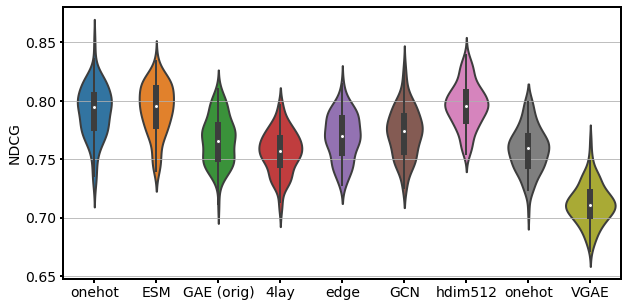

In [4]:
os.chdir('/scratch/ml/jyang4/ProtGraphR/analysis')
ndcgs = np.load('ndcg_384.npy')
#df_ndcg = pd.DataFrame(data=ndcgs, columns= ['onehot', 'ESM','GAE (orig)', '4lay', 'edge', 'GCN', 'hdim512', 'onehot', 'VGAE'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = ndcgs)
ax.set_xticklabels(['onehot', 'ESM','GAE (orig)', '4lay', 'edge', 'GCN', 'hdim512', 'onehot', 'VGAE'])
ax.set_ylabel('NDCG')
plt.savefig('384.svg')

In [4]:
# files = os.listdir('/scratch/ml/fzl/p2g/data/GB1_Wu_2016/embeddings/esm1_t12_85M_UR50S_noflatten/')
# esm = []

# pbar = tqdm()
# pbar.reset(total=len(files))

# for file in files:
#     file = os.path.join('/scratch/ml/fzl/p2g/data/GB1_Wu_2016/embeddings/esm1_t12_85M_UR50S_noflatten/', file) 
#     data = np.mean(np.load(file)['embedding'], axis = 0)
#     esm.append(data)
#     pbar.update()

0it [00:00, ?it/s]

In [9]:
embeddings.shape

(149361, 128)

In [8]:
#downstream supervised regression
N_models = 100
N_train_samples = 384
n_splits = 5

all_results_ndcg = []

for i, experiment in enumerate(['onehot']):
    os.chdir('/scratch/ml/jyang4/ProtGraphR/analysis')
    if experiment == 'ESM':
        dataframe = pd.read_csv('fitness_esm_order.csv')
        embeddings2 = np.load('esm.npy')
        X = embeddings2
    elif experiment == 'onehot':
        dataframe = pd.read_csv('fitness.csv')
        dataset = GB1Dataset(dataframe = dataframe, encoding = 'one-hot', attribute_names = ["EvMutation", "Triad-FixedBb-dG"])
        dataset.encode_X()
        #X = dataset.X
        X = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
        print(X.shape)
    else:
        dataframe = pd.read_csv('fitness.csv')
        os.chdir('/scratch/ml/jyang4/ProtGraphR/saved/' + experiment + '/')
        embeddings = np.load('embeddings.npy')
        X = embeddings
    
    y = dataframe['fit'].values

    seed = 0
    X, y = shuffle(X, y, random_state=seed)
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train_all = X
    y_train_all = y

    results_ndcg = []
    y_pred_tests = np.zeros((n_splits, len(X_train_all)))

    np.random.seed(42)
    for i in range(N_models):
        X_resample, y_resample = resample(X_train_all, y_train_all, n_samples=N_train_samples)
        kf = KFold(n_splits=n_splits)
        clfs = []
        
        for i, (train_index, test_index) in enumerate(kf.split(X_resample)):
            X_train, X_test = X_resample[train_index], X_resample[test_index]
            y_train, y_test = y_resample[train_index], y_resample[test_index]
            
            #clf = Ridge(alpha=1)
            clf = LinearRegression()
            clf.fit(X_train, y_train)
            clfs.append(clf)

            y_pred_tests[i] = clf.predict(X_train_all)

        y_pred_test = np.mean(y_pred_tests, axis = 0)
        
        results_ndcg.append(ndcg(y_train_all, y_pred_test))
    all_results_ndcg.append(results_ndcg)
    print('done')

(149361, 102)
done


In [9]:
np.mean(all_results_ndcg, axis = 1)

array([0.79474984])

In [25]:
os.chdir('/scratch/ml/jyang4/ProtGraphR/analysis')
np.save('ndcg_48.npy', np.array(all_results_ndcg).T)

In [34]:
model_params = {"booster": "gbtree",
                      "tree_method": "exact",
                      "nthread": 1,
                      "objective": "reg:tweedie",
                      "tweedie_variance_power": 1.5,
                      "eval_metric": "tweedie-nloglik@1.5",
                      "eta": 0.3,
                        "max_depth": 6,
                        "lambda": 1,
                        "alpha": 0
                      }

linear = True
# model_params = {"booster": "gblinear",
#                       "tree_method": "exact",
#                       "nthread": 1,
#                       "verbosity": 0,
#                       "objective": "reg:tweedie",
#                       "tweedie_variance_power": 1.5,
#                       "eval_metric": "tweedie-nloglik@1.5"}

In [ ]:
#how listgarten split their dataset
# data = dataset.data.sample(frac=1.0, random_state=0)
# test = data.sample(frac=0.2, random_state=0)
# test

In [35]:
#downstream supervised regression
N_models = 100
N_train_samples = 384

#only necessary if you are testing the top 96, otherwise defaults to a fixed test set
N_test_samples = 96
alpha_list = [1]
#alpha_list = [10**2.5]
#alpha_list = [5**i for i in range(-5,5)]


X_baseline = np.array(dataset.X)
X_embed = np.array(embeddings)
#X_embed = np.array(likelihoods)

X_OHembed = np.concatenate((np.array(dataset.X), np.array(embeddings)), axis=1)

X_zs = np.array(dataset.attributes)

X_OHzs = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
#X_OHzs = np.concatenate((np.array(dataset.X), np.array(log_probs['log_prob']).reshape(-1, 1)), axis=1)
#X_OHzs = np.concatenate((np.array(dataset.X), np.array(dataframe['EVMutation']).reshape(-1,1)), axis=1)

X_all = np.concatenate((np.array(dataset.X), np.array(dataset.attributes), np.array(embeddings)), axis=1)

#X_zs = np.array(dataframe['EVMutation']).reshape(-1,1)

inputs = [X_baseline, X_embed, X_zs, X_OHembed, X_OHzs, X_all]
#inputs = [X_OHzs]

results_ndcg = np.zeros((N_models, len(inputs), len(alpha_list)))
results_rho = np.zeros((N_models, len(inputs), len(alpha_list)))
np.random.seed(42)

for k, alpha in enumerate(alpha_list):
    for j, X in enumerate(inputs):
        #do not normalize! it will break the OH+ZS results!
        #scaler = StandardScaler()
        #X = scaler.fit_transform(X)
        #y = dataset.y
        y = dataframe['log_fitness'].values

        seed = 0
        X, y = shuffle(X, y, random_state=seed)
        X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        #print(len(y_test))

        np.random.seed(42)
        for i in range(N_models):
            X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples)
            #only run this line if you wish to use a different test size
            #X_test, y_test = resample(X, y, n_samples=N_test_samples)

            if linear:
                clf = Ridge(alpha=alpha)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
            else:
                #insert kfold cross validation
                train_matrix = xgb.DMatrix(X_train, label = y_train)

                # in reality we should use a validation set, not the test set
                test_matrix = xgb.DMatrix(X_test, label = y_test)
                evallist = [(train_matrix, "train"), (test_matrix, "test")]
                bst = xgb.train(model_params, train_matrix, num_boost_round=1000, early_stopping_rounds=10, evals=evallist, verbose_eval=False)
                best = bst.best_iteration
                y_pred_test = bst.predict(xgb.DMatrix(X_test), iteration_range=(0,best))

                # y_pred = bst.predict(xgb.DMatrix(X), iteration_range=(0,best))
                # df = pd.DataFrame(X)
                # df['y_pred'] = y_pred
                # df['y'] = y
                # df = df.sort_values('y_pred',ascending = False)
                # df =df.reset_index()
                # y_pred_top = df.loc[:N_test_samples-1,'y_pred'].values
                # y_top = df.loc[:N_test_samples-1,'y'].values

            #results_ndcg[i, j] = ndcg(y_top, y_pred_top)
            #results_rho[i, j] = spearmanr(y_top, y_pred_top)[0]

            results_ndcg[i, j, k] = ndcg(y_test, y_pred_test)
            results_rho[i, j, k] = spearmanr(y_test, y_pred_test)[0]

            #exponentiate if the fitness was logged
            #results_ndcg[i, j, k] = ndcg(np.exp(y_test), np.exp(y_pred_test))
            #results_rho[i, j, k] = spearmanr(np.exp(y_test), np.exp(y_pred_test))[0]

NameError: name 'embeddings' is not defined

In [ ]:
#for testing individual models
# scaler = StandardScaler()
# X = scaler.fit_transform(X_baseline)
# y = dataset.y

# X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples, random_state=0)
# #print(spearmanr(X_train, y_train)[0])

# clf = Ridge(alpha=1)
# clf.fit(X_train, y_train)
# y_pred_test = clf.predict(X_test)
# print(spearmanr(y_pred_test, y_test)[0])

In [ ]:
#for visualizing the optimal hyperparameters
#plt.plot(np.log10(alpha_list), np.mean(results_rho, axis = 0).T, '-')

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


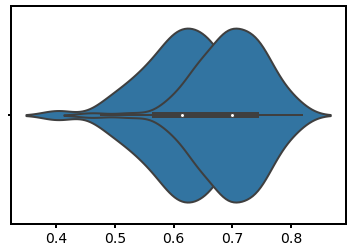

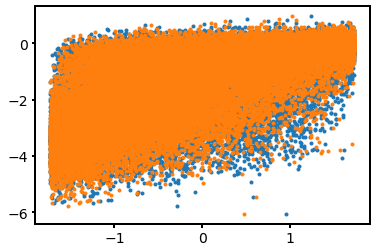

In [14]:
data = dataset.data
all_all_scores = np.array(dataset.attributes)#.reshape(-1)
#all_all_fitness = np.array(dataset.y)#.reshape(-1)#[:100]
all_all_fitness = np.array(dataframe['log_fitness'].values)

ndcgs = np.zeros((N_models, all_all_scores.shape[1]))
rhos = np.zeros((N_models, all_all_scores.shape[1]))
np.random.seed(42)
for j in range(all_all_scores.shape[1]):
    all_scores = all_all_scores[:,j]
    for i in range(N_models):
        scores, fitness = resample(all_scores, all_all_fitness, n_samples=N_train_samples)
        ndcgs[i,j] = ndcg(fitness, scores)
        rhos[i,j] = spearmanr(fitness, scores)[0]

#ax = sns.violinplot(ndcgs)
for i in range(all_all_scores.shape[1]):
    ax = sns.violinplot(rhos[:,i])

plt.figure()
plt.plot(all_all_scores, all_all_fitness, '.')

OH rho           0.516418
 Emb rho         0.501053
ZS rho           0.710837
OH+Emb rho       0.581365
OH+ZS rho        0.751979
OH+Emb+ZS rho    0.749831
dtype: float64


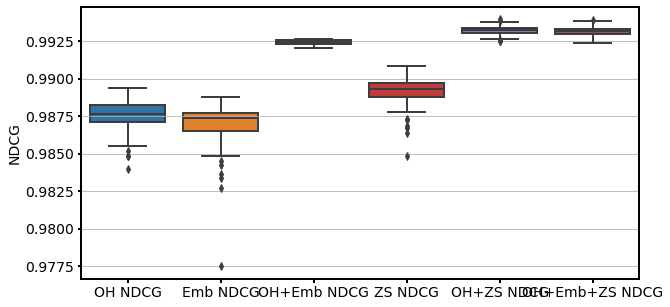

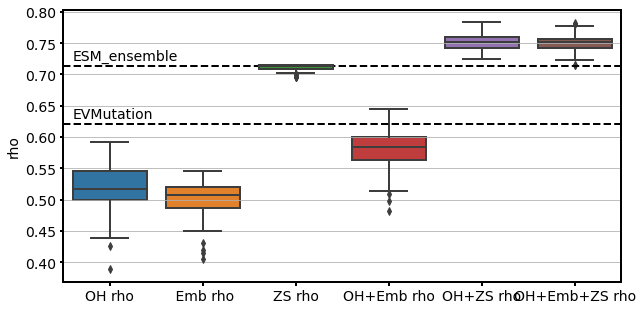

In [15]:
#increasing the NDCG increase ridge model performance
df_ndcg = pd.DataFrame(data=results_ndcg.reshape(100,6), columns= ['OH NDCG', 'Emb NDCG', 'OH+Emb NDCG', 'ZS NDCG', 'OH+ZS NDCG', 'OH+Emb+ZS NDCG'])
df_rho = pd.DataFrame(data=results_rho.reshape(100,6), columns= ['OH rho',' Emb rho', 'ZS rho','OH+Emb rho','OH+ZS rho', 'OH+Emb+ZS rho'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.boxplot(data = df_ndcg)
#plt.axhline(y = ndcg(all_all_fitness, all_scores), color = 'k', linestyle = '--')
plt.ylabel('NDCG')
#plt.savefig('384_96_xgb_NDCG.jpg')

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.boxplot(data = df_rho)
for i in range(all_all_scores.shape[1]):
    value = spearmanr(all_all_fitness, all_all_scores[:,i])[0]
    plt.axhline(y = value, color = 'k', linestyle = '--')
    plt.text(-0.4, value+0.01, attribute_names[i])
plt.ylabel('rho')
# value = spearmanr(np.array(dataframe['log_fitness']), np.array(dataframe['log_prob']))[0]
# plt.axhline(y = value, color= 'k', linestyle = '--')
# plt.text(-0.4, value+0.01, 'prob_MSA_VAE')

print(np.mean(df_rho, axis =0))
#plt.savefig('384_96_xgb_rho.jpg')
plt.savefig('figures/boxplot2.eps')


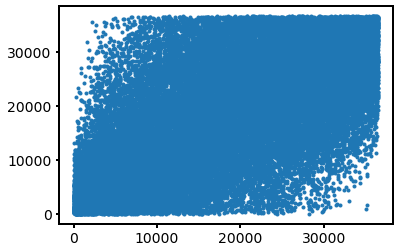

In [8]:
plt.plot(dataset.data['EVMutation'].rank(), dataset.data['log_fitness'].rank(), '.')

In [ ]:
ax = sns.jointplot(x = y_pred_test,y = y_test)
plt.xlabel('Predicted fitness')
plt.ylabel('Actual fitness')

In [ ]:
plt.hist(y_test)
plt.hist(y_pred_test)
plt.yscale('log')